In [1]:
import importlib
from pathlib import Path
from IPython.display import Image, HTML, Markdown, display
from ploomber_basic import pipeline

# Ploomber tutorial

This example project showcases the basic Ploomber experience, hopefully, this interactive tutorial will convince you to try out Ploomber in your next Data Science project.

Let's imagine you already have a Ploomber pipeline, which is organized in a few tasks. Ploomber allows you to quickly iterate by keeping track of source code changes and skipping unnecessary computations.

Let's first retrieve our pipeline:

In [2]:
dag = pipeline.make()

Plotting it makes easy to understand dependencies between tasks, each node corresponds to one.

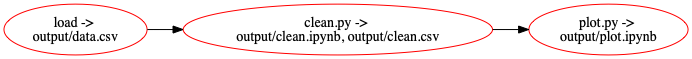

In [3]:
Image(filename=dag.plot())

Our pipeline has three tasks: load, clean and plot. Ploomber will keep track of your source code and mark as outdated any task that changed since last execution. Making your whole pipeline up-to-date is as simple as running:

In [4]:
dag.build()

name,Ran?,Elapsed (s),Percentage
load,True,0.01561,0.33485
clean.py,True,1.5377,32.9853
plot.py,True,3.10848,66.6799


Let's see what happens if we build again:

In [5]:
dag.build()

name,Ran?,Elapsed (s),Percentage
load,False,0,0
clean.py,False,0,0
plot.py,False,0,0


It didn't run anything! That's because our pipeline has not changed, there is nothing to run.

Our `dag` object is a fully interactive way of exploring our pipeline. Let's use the DAG object to know where our code is located:

In [6]:
# get list of task names
list(dag)

['load', 'clean.py', 'plot.py']

In [7]:
# get task
task = dag['load']

# print source code
print(task.source)

# where is this code declared?
print(task.source.loc)

def load(product):
    df = pd.DataFrame({'x': np.random.rand(500)})
    df['x'] = df['x'] + 1
    df.to_csv(str(product), index=False)

/Users/Edu/dev/projects-ploomber/basic-tutorial/src/ploomber_basic/functions.py:5


Go ahead and modify the function, for example, instead of having:


```python
df['x'] = df['x'] = 1
```

Replace it with (or anything you want):

```python
df['x'] = df['x'] = 2
```


[Click here to open the notebook](src/ploomber_basic/notebooks/functions.py)

Then come back and run:

In [8]:
dag.build()

name,Ran?,Elapsed (s),Percentage
load,False,0,0
clean.py,False,0,0
plot.py,False,0,0


You should see that all three tasks ran again, that's because the load function is the root node. Let's try with another task:

In [9]:
print(dag['clean.py'].source.loc)

/Users/Edu/dev/projects-ploomber/basic-tutorial/src/ploomber_basic/notebooks/clean.py


Go ahead and modify the file.

[Click here to open the notebook](src/ploomber_basic/notebooks/clean.py)

Then run:

In [10]:
dag.build()

name,Ran?,Elapsed (s),Percentage
load,False,0,0
clean.py,False,0,0
plot.py,False,0,0


You should see that Ploomber skipped running the load task since modifying the clean task didn't change it. You can save a lot of time by letting Ploomber automatically figure out which tasks to run, especially when those computations take a lot of time to run.

Let's take a look at the actual pipeline declaration, where we'll find a bunch of interesting things.

In [11]:
Markdown("""
```python
{}
```
""".format(Path(pipeline.__file__).read_text()))


```python
import shutil
from pathlib import Path

from ploomber_basic import functions

from ploomber import DAGConfigurator, SourceLoader
from ploomber.tasks import NotebookRunner, PythonCallable
from ploomber.products import File


def make(clean_up=True):
    cfg = DAGConfigurator()
    cfg.params.hot_reload = True
    dag = cfg.create()

    # we will save all output here
    out = Path('output')

    if clean_up and out.exists():
        shutil.rmtree(str(out))

    out.mkdir(exist_ok=True)

    # source loaders allows us to easily load files from modules
    loader = SourceLoader(path='notebooks', module='ploomber_basic')

    # our first task is a Python function, it generates and output csv file
    load = PythonCallable(functions.load,
                          product=File(out / 'data.csv'),
                          dag=dag,
                          name='load')

    # Our second task is a Python script. Since we are using the NotebookRunner
    # task, it will convert it to a Jupyter notebook before execution (you can
    # still pass a .ipynb file). We recommend using .py files as they are
    # easier to merge with git
    clean = NotebookRunner(loader['clean.py'],
                           # this task generates two files, the .ipynb
                           # output notebook and another csv file
                           product={'nb': File(out / 'clean.ipynb'),
                                    'data': File(out / 'clean.csv')},
                           dag=dag,
                           # you can run any language supported by Jupyter
                           # by specifying which kernel to use
                           kernelspec_name='python3',
                           # by enabling this option, a few checks are
                           # performed on your code before running the
                           # notebook. Given that jupyter notebooks are run
                           # cell by cell, something as simple as a syntax
                           # error will be discovered until such cell is run,
                           # this gives you immediate feedback
                           static_analysis=True,
                           papermill_params={'nest_asyncio': True})

    # the final task is also a notebook that generates a plot
    plot = NotebookRunner(loader['plot.py'],
                          File(out / 'plot.ipynb'),
                          dag=dag,
                          kernelspec_name='python3',
                          static_analysis=True,
                          papermill_params={'nest_asyncio': True})

    # declare execution dependencies, by leveraging the graph structure
    # Ploomber can even run tasks in parallel
    load >> clean >> plot

    return dag

```


You've made it to the end of this tutorial. Hopefully this will convince you to give Ploomber a try. Don't hesitate with any questions you might have. Feel free to [open an issue](https://github.com/ploomber/ploomber/issues/new) in the repository. Thanks for reading!

## Where to go from here

* Take a look at our [documentation](https://ploomber.readthedocs.io/en/stable/)
* Dive into our [codebase](https://github.com/ploomber/ploomber)